In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils.datasets.fer
import os
%matplotlib inline

import scipy

from utils import datasets

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.11.0


## Plot Sample Image

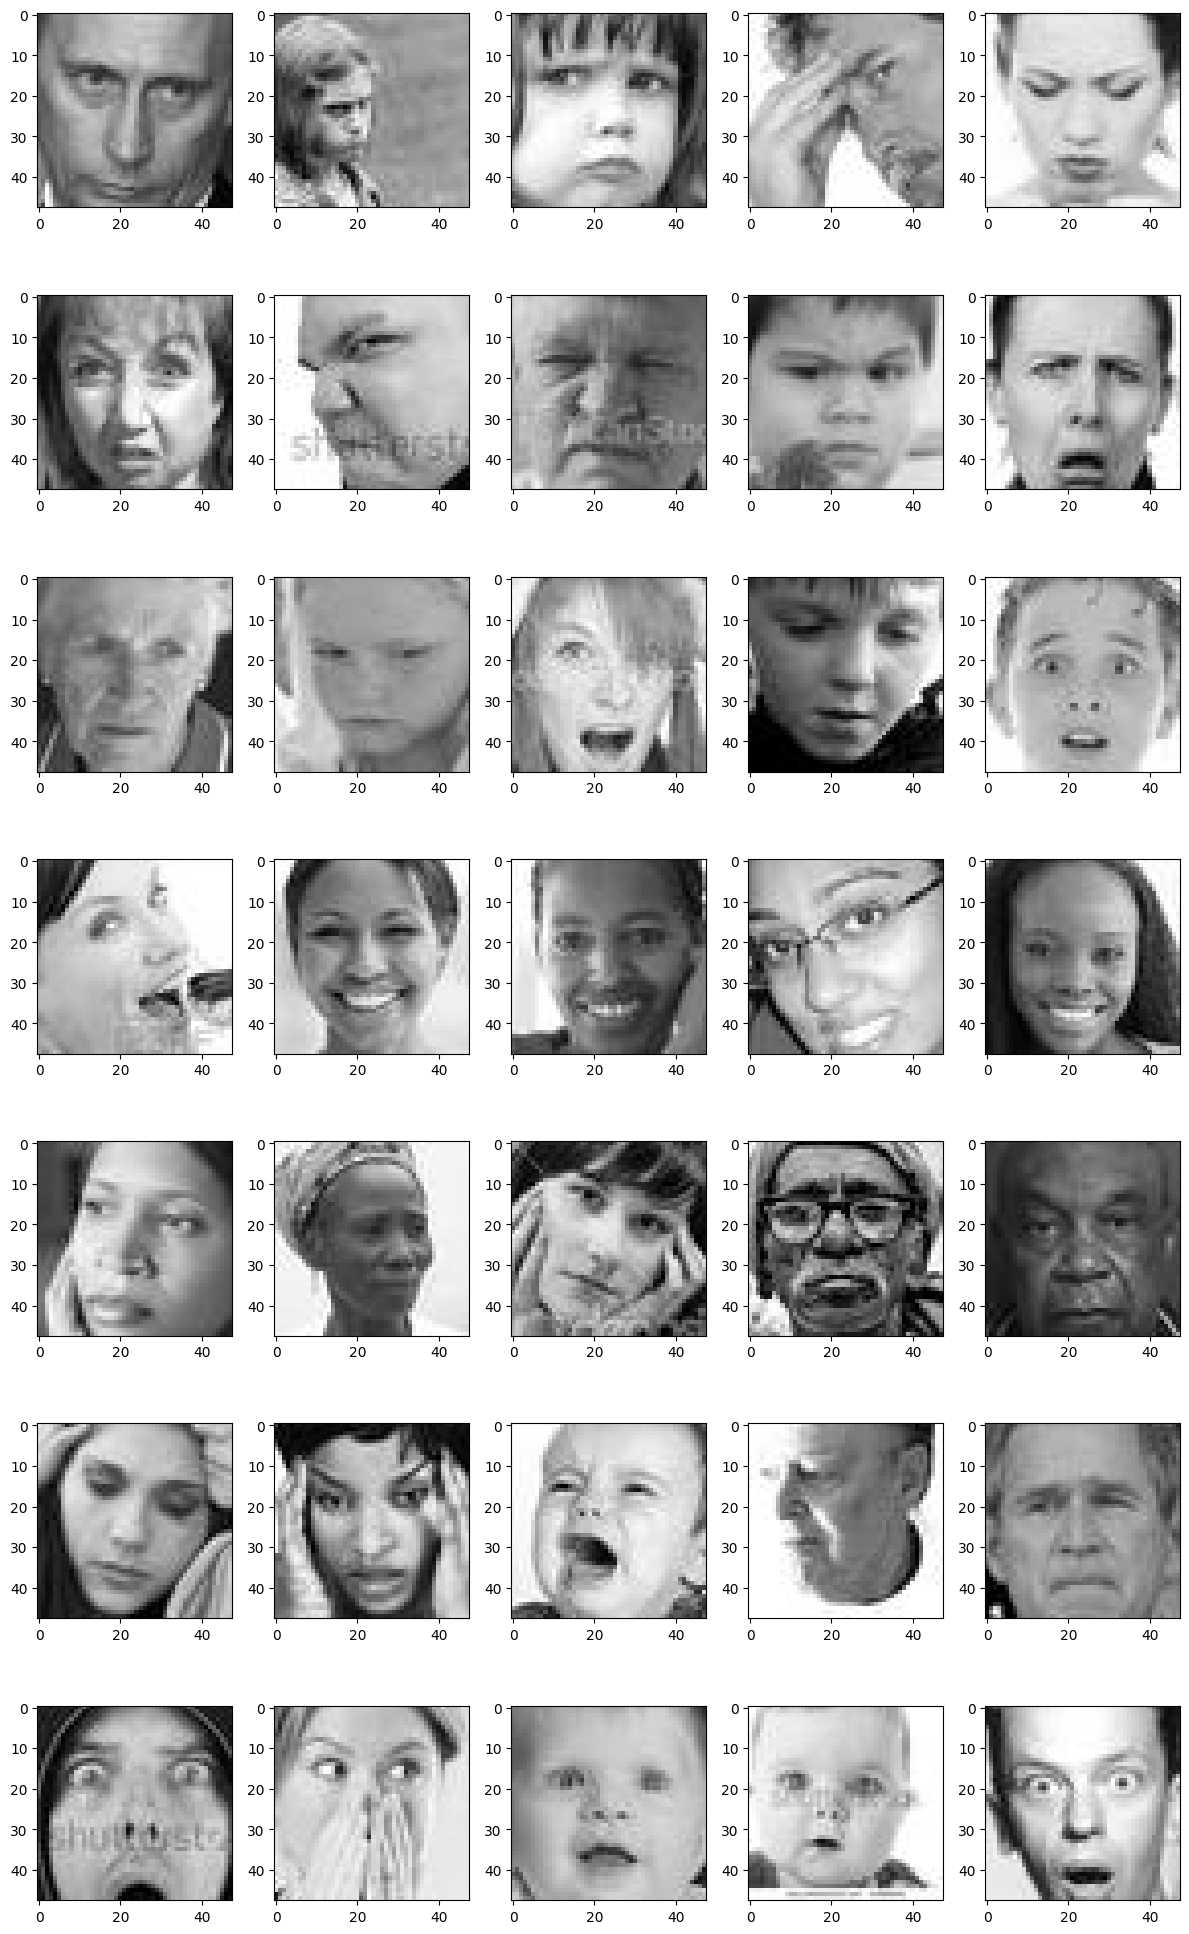

In [2]:
datasets.fer.plot_example_images(plt).show()

In [3]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")

3995 angry images
436 disgust images
4097 fear images
7215 happy images
4965 neutral images
4830 sad images
3171 surprise images


## Generate Training and Validation Batches

In [4]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("train/", 
                                                    target_size=(img_size, img_size),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_train.flow_from_directory("test/", 
                                                    target_size=(img_size, img_size),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Create CNN Model

In [5]:
model = Sequential()

# 1 - conv
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 - conv layer
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3 - conv layer
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4 - conv layer
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

## Train and Evaluate Model

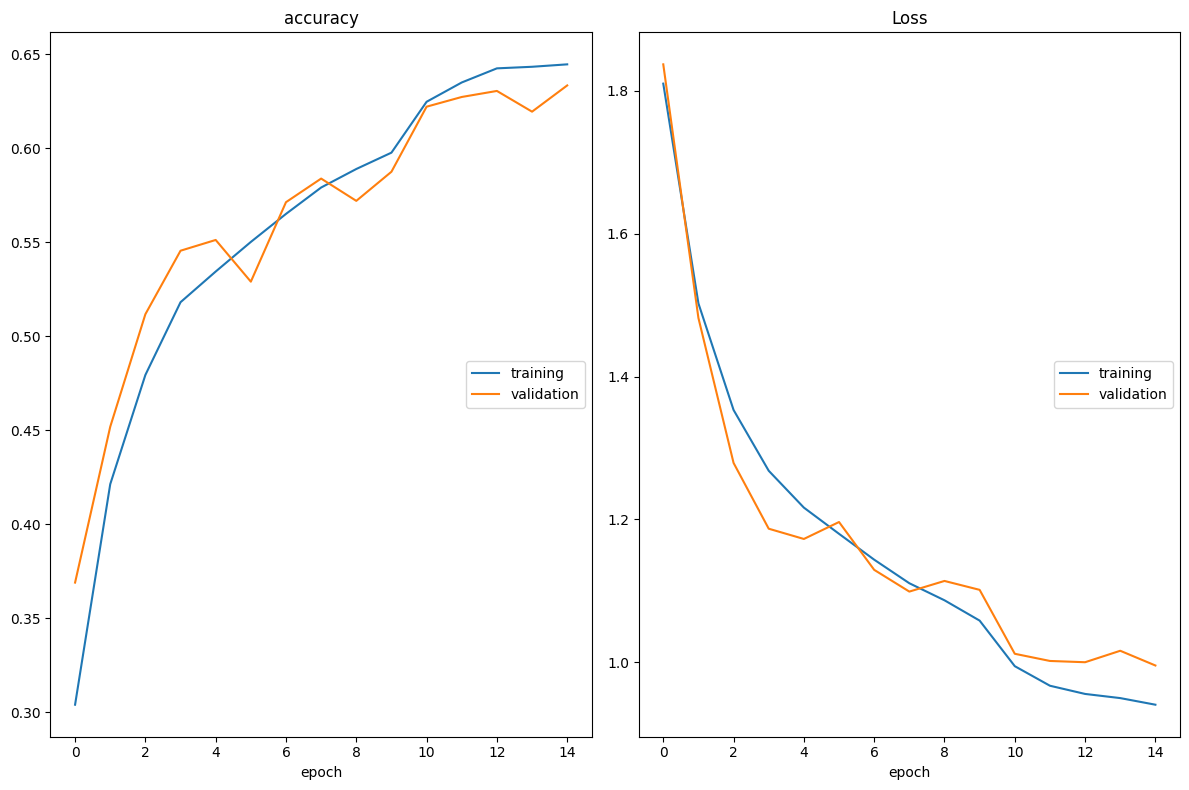

accuracy
	training         	 (min:    0.304, max:    0.645, cur:    0.645)
	validation       	 (min:    0.369, max:    0.633, cur:    0.633)
Loss
	training         	 (min:    0.941, max:    1.810, cur:    0.941)
	validation       	 (min:    0.995, max:    1.837, cur:    0.995)

Epoch 15: saving model to model_weights.h5
448/448 [==============================] - 848s 2s/step - loss: 0.9406 - accuracy: 0.6446 - val_loss: 0.9955 - val_accuracy: 0.6334 - lr: 5.0000e-05


In [6]:
epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, model='auto')

callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(x=train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=validation_generator, 
                    validation_steps=validation_steps, 
                    callbacks=callbacks)

## Represent Model as JSON String

In [8]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)